# LSTM
upload sim_seq_1_train_sequences2.txt

<ipython-input-1-87837ad229e7>:40: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  training_data = numpy.genfromtxt(training_data_fn, delimiter="\t", dtype=None,


Streaming output truncated to the last 5000 lines.
        [3.],
        [1.],
        [2.],
        [2.],
        [2.],
        [2.],
        [5.],
        [2.],
        [5.],
        [3.],
        [1.],
        [3.],
        [1.],
        [2.],
        [3.],
        [5.],
        [1.],
        [5.],
        [3.],
        [3.],
        [2.],
        [4.],
        [5.],
        [2.],
        [3.],
        [4.],
        [4.],
        [5.],
        [2.],
        [1.],
        [4.],
        [3.],
        [3.],
        [2.],
        [2.],
        [5.],
        [2.],
        [4.],
        [3.],
        [2.],
        [2.],
        [2.],
        [2.],
        [1.],
        [2.],
        [1.],
        [5.],
        [1.],
        [2.],
        [4.],
        [5.],
        [5.],
        [5.],
        [5.],
        [2.],
        [4.],
        [2.],
        [4.],
        [4.],
        [1.],
        [3.],
        [4.],
        [2.],
        [4.],
        [5.],
        [1.],
        [4.],
        [2.

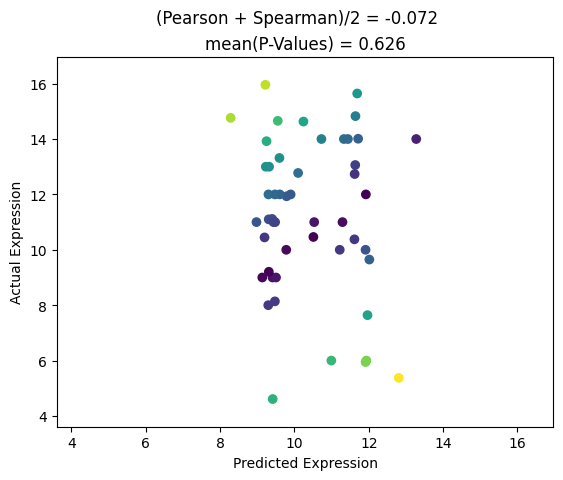

7.432386875152588
Pearson r=-0.097, P-Value=0.502
Spearman correlation=-0.046, P-Value=0.751


In [1]:
# from https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

import matplotlib.pyplot as plt
from scipy import stats
import torch
import torch.nn as nn
import numpy


class SeqLSTM(nn.Module):
    def __init__(self, input_size, _hidden_size, _num_layers, _output_size):
        super(SeqLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = _hidden_size
        self.output_size = _output_size
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=_hidden_size,
                            num_layers=_num_layers,
                            dropout=0.1)
        self.linear = nn.Linear(_hidden_size, _output_size)

    def forward(self, _input):
        lstm_out, _ = self.lstm(_input)
        linear_out = self.linear(lstm_out)
        return linear_out


MAX_ROWS = 100
HALF_ROWS = MAX_ROWS // 2
NUM_EPOCHS = 1000
max_seq_length = 111
hidden_size = 5
num_layers = 2
output_size = 1

torch.manual_seed(1)

training_data_fn = "sim_seq_1_train_sequences2.txt" #"/home/jgburk/PycharmProjects/IntroductionToDeepLearning/TF_Data/sim_seq_1_train_sequences.txt"

training_data = numpy.genfromtxt(training_data_fn, delimiter="\t", dtype=None,
                                 skip_header=0, max_rows=MAX_ROWS)
training_sequences = list()
training_expression = list()
mapper = dict([(ord('A'), 1.0),
               (ord('T'), 2.0),
               (ord('C'), 3.0),
               (ord('G'), 4.0),
               (ord('N'), 5.0)])
for row in training_data:
    ts = torch.FloatTensor([[mapper[x] for x in row[0]]]).transpose(0, 1)
    print(ts)
    training_sequences.append(ts)
    training_expression.append(torch.FloatTensor([row[1]]))

# working through https://stackoverflow.com/questions/56783182/runtimeerror-the-size-of-tensor-a-133-must-match-the-size-of-tensor-b-10-at
t_s = torch.nn.utils.rnn.pad_sequence(training_sequences, batch_first=True)
t_e = torch.cat(training_expression)

model = SeqLSTM(max_seq_length, hidden_size, num_layers, output_size)
train_inputs = t_s[0:MAX_ROWS:2, :, :]
test_inputs = t_s[1:MAX_ROWS:2, :, :]
train_targets = t_e[0:MAX_ROWS:2]
test_targets = t_e[1:MAX_ROWS:2]
print(f'inputs.shape: {train_inputs.shape}')

loss_fn = nn.L1Loss()
optimizer = torch.optim.AdamW(model.parameters())

for epoch in range(NUM_EPOCHS):
    loss_sum = 0.0
    for idx, _input in enumerate(train_inputs):
        optimizer.zero_grad()
        score = model(_input.transpose(0, 1))
        loss = loss_fn(score, train_targets[idx].view(1, -1))
        loss.backward()
        loss_sum = loss_sum + torch.abs(loss)
        optimizer.step()
    print(f'Epoch {epoch}, Loss: {loss_sum / len(train_inputs)}')

pred_l = list()
actual_l = list()
loss_sq_l = list()
for idx, test_input in enumerate(test_inputs):
    pred = model(test_input.transpose(0, 1))
    pred = pred.item()
    actual = test_targets[idx]
    actual = actual.item()
    loss = pred - actual
    print(f'loss[{idx}]: {loss}')
    pred_l.append(pred)
    actual_l.append(actual)
    loss_sq_l.append(abs(loss))


psn = stats.pearsonr(x=pred_l, y=actual_l)
spn = stats.spearmanr(a=pred_l, b=actual_l)
plt.scatter(x=pred_l, y=actual_l, c=loss_sq_l)
plt.xlim([min(pred_l + actual_l) - 1, max(pred_l + actual_l) + 1])
plt.ylim([min(pred_l + actual_l) - 1, max(pred_l + actual_l) + 1])
plt.xlabel("Predicted Expression")
plt.ylabel("Actual Expression")
plt.suptitle(f'(Pearson + Spearman)/2 = {round((psn[0] + spn.correlation)/2.0,ndigits=3)}')
plt.title(f'mean(P-Values) = {round((psn[1] + spn.pvalue)/2.0,ndigits=3)}')
plt.show()
print(max(loss_sq_l))
print(f'Pearson r={round(psn[0], ndigits=3)}, P-Value={round(psn[1], ndigits=3)}')
print(f'Spearman correlation={round(spn.correlation, ndigits=3)}, P-Value={round(spn.pvalue, ndigits=3)}')